In [1]:
import sys
sys.path.insert(0, "/afs/ir/users/c/j/cjbillov/.local/lib/python2.7/site-packages")
sys.path.append('..')
print sys.path
import lasagne
print lasagne.__version__

from util.data_utils import get_CIFAR10_data

!export THEANO_FLAGS='floatX=float32'


['/afs/ir/users/c/j/cjbillov/.local/lib/python2.7/site-packages', '', '/usr/local/lib/python2.7/site-packages', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python27.zip', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-darwin', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac/lib-scriptpackages', '/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-tk', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-old', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload', '/Users/chris/Library/Python/2.7/lib/python/site-packages', '/usr/local/Cellar/numpy/1.9.2/libexec/nose/lib/python2.7/site-packages', '/Sys

In [2]:
# Autoencoder

import numpy as np
import matplotlib
matplotlib.use('MacOSX')
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
from theano import pp
import time

import lasagne
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer, InverseLayer

from lasagne.utils import floatX
from lasagne.updates import adam
from lasagne.nonlinearities import softmax



In [76]:
data = np.array( np.random.random((1024, 128)), dtype=np.float32)

img_data = get_CIFAR10_data()

In [4]:
# import stephanie


with open('/Users/chris/Documents/StephaniePants.jpeg') as f:
    img = plt.imread (f)
    print type(img)
    print img.shape
    
data = np.transpose(img, (2, 0, 1))[None, :, :, :]
data = data.reshape(1, -1)
print data.shape

data = np.float32(data) / 255.0

<type 'numpy.ndarray'>
(278, 326, 3)
(1, 271884)


In [77]:
# for k, v in img_data.iteritems():
#   print '%s: ' % k, v.shape

X_val = img_data['X_val']
X_val = np.array( X_val.reshape((1000, -1)), dtype=np.float32)
print X_val.shape
data = X_val
y = data 

(1000, 3072)


In [51]:
# Make lasagne layers

# input_var = T.matrix('inputs')
# target_var = T.matrix('targets')

# net = {}
# net['input'] = InputLayer ((None, 128), input_var=input_var)
# net['h1'] = DenseLayer(net['input'], num_units=64, nonlinearity=T.nnet.relu,
#                                        W=lasagne.init.HeNormal(gain='relu') )
# net['h2'] = DenseLayer(net['h1'], num_units=32, nonlinearity=T.nnet.relu, 
#                                        W=lasagne.init.HeNormal(gain='relu') )
# net['h3'] = DenseLayer(net['h2'], num_units=16, nonlinearity=T.nnet.relu, 
#                                        W=lasagne.init.HeNormal(gain='relu') )
# net['h4'] = DenseLayer(net['h3'], num_units=8, nonlinearity=T.nnet.relu, 
#                                        W=lasagne.init.HeNormal(gain='relu') )
# net['h4_inv'] = InverseLayer(net['h4'], net['h4'])
# net['h3_inv'] = InverseLayer(net['h4_inv'], net['h3'])
# net['h2_inv'] = InverseLayer(net['h3_inv'], net['h2'])
# net['h1_inv'] = InverseLayer(net['h2_inv'], net['h1'])

hidden_sizes = [256, 64]
input_var = T.matrix('inputs')
target_var = T.matrix('targets')

names = ['h{0}'.format(i) for i in xrange(len(hidden_sizes))]
inv_names = ['h{0}_inv'.format(i) for i in xrange(len(hidden_sizes))][::-1]
net = {}

print names, inv_names

net['input'] = InputLayer ((None, 271884), input_var=input_var)

prev = net['input']
for i, name in enumerate(names):
    net[name] = DenseLayer(prev, num_units=hidden_sizes[i], 
                                 nonlinearity=T.nnet.relu,
                                 W=lasagne.init.HeNormal(gain='relu') )
    prev = net[name]


# Build reverse layers
for j, name in enumerate(inv_names):
    print names[-j-1]
    net[name] = InverseLayer(prev, net[names[-j-1]])
    prev = net[name]



['h0', 'h1'] ['h1_inv', 'h0_inv']
h1
h0


In [52]:
params = lasagne.layers.get_all_params(net['h0_inv'], trainable=True)
out = lasagne.layers.get_output(net['h0_inv'], deterministic=True)

loss = lasagne.objectives.squared_error(out, target_var)
adam_update = adam (loss.mean(), params, learning_rate=9e-5)

train_function = theano.function([input_var, target_var], loss, updates=adam_update)

In [7]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    """
    Get minibatch for data.
    :param inputs:
    :param targets:
    :param batchsize:
    :param shuffle:
    :return:
    """
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [53]:
def train(x=data, y=data, num_epochs=16):
    batch_size = 1
    print x.dtype
    print y.dtype
    print("Starting training...")
    # We iterate over epochs:
    start_time = time.time()
    for epoch in range(num_epochs):
        
        if epoch % 2 == 0:
            #print 'epoch {0} done after {1} seconds'.format(epoch, time.time() - start_time)
            compressed = np.array(lasagne.layers.get_output(net['h0_inv'], data, deterministic=True).eval())
            compressed = compressed.reshape((3, 278, 326))
            #print compressed.shape
            imshow_noax(np.transpose(compressed, (2, 1, 0)))
            plt.show()
            plt.pause(0.01)
            
        # In each epoch, we do a full pass over the training data:
        train_err = 0.0
        train_batches = 0
        
        for batch in iterate_minibatches(x, y, batch_size, shuffle=True):
            inputs, targets = batch
            train_function(inputs, targets)
            train_batches += 1
        


        
    

float32
float32
Starting training...


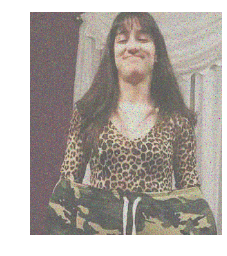

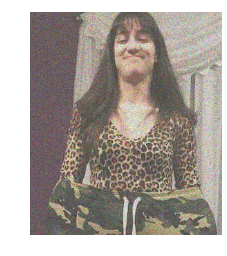

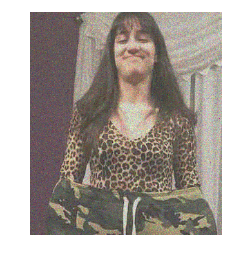

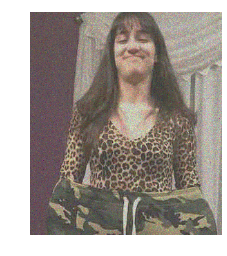

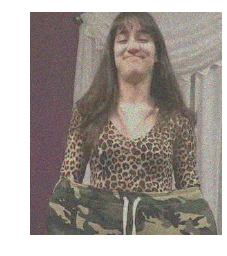

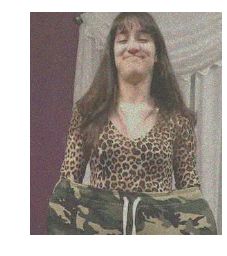

KeyboardInterrupt: 

In [55]:
%matplotlib inline
y = data
train(data, y)

#### param_values = lasagne.layers.get_all_param_values(net['h1_inv'])
W1, b1, W2, b2 = param_values
print W1.shape, W2.shape

In [29]:
compressed = np.array(lasagne.layers.get_output(net['h0_inv'], data, deterministic=True).eval())


In [10]:
#compressed = compressed.reshape((1, 3, 278, 326))
#print compressed.shape

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

(3, 278, 326)
(1, 326, 278, 3)


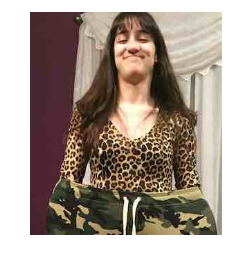

In [24]:
%matplotlib inline
print compressed[0].shape

normed_data = data.reshape((1, 3, 278, 326))
normed_data = np.transpose(normed_data, (0, 3, 2, 1))
print normed_data.shape

# #imshow_noax(compressed[0])
imshow_noax(normed_data[0])
#imshow_noax(np.transpose(compressed[9], (1, 2, 0)))

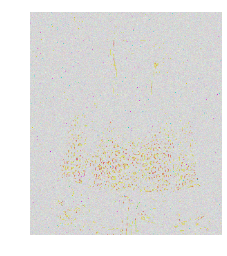

In [31]:
imshow_noax(np.transpose(compressed[0], (2, 1, 0)))